In [1]:
import numpy as np
import pandas as pd

emb = np.load("../data/gravityspy_processed/embeddings.npy")
meta = pd.read_csv("../data/gravityspy_processed/embeddings_metadata.csv")

emb.shape, meta.head()


((34332, 512),
                                                 path  label_idx label_name
 0  C:\Users\mygam\Documents\gravityspy-project\da...          0       H1L1
 1  C:\Users\mygam\Documents\gravityspy-project\da...          0       H1L1
 2  C:\Users\mygam\Documents\gravityspy-project\da...          0       H1L1
 3  C:\Users\mygam\Documents\gravityspy-project\da...          0       H1L1
 4  C:\Users\mygam\Documents\gravityspy-project\da...          0       H1L1)

In [2]:
meta["label_name"].value_counts().head(20)


label_name
H1L1    34332
Name: count, dtype: int64

In [3]:
import umap

umap_2d = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
)

coords_2d = umap_2d.fit_transform(emb)
coords_2d.shape


C:\Users\mygam\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mygam\AppData\Roaming\Python\Python313\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(34332, 2)

In [4]:
meta["umap_x"] = coords_2d[:, 0]
meta["umap_y"] = coords_2d[:, 1]

meta.to_csv("../data/gravityspy_processed/embeddings_umap.csv", index=False)
meta.head()


,path,label_idx,label_name,umap_x,umap_y
0,C:\Users\mygam\Documents\gravityspy-project\da...,0,H1L1,-0.348981,-9.599299
1,C:\Users\mygam\Documents\gravityspy-project\da...,0,H1L1,-4.094698,-4.398118
2,C:\Users\mygam\Documents\gravityspy-project\da...,0,H1L1,-3.336335,1.403767
3,C:\Users\mygam\Documents\gravityspy-project\da...,0,H1L1,-3.679747,8.008952
4,C:\Users\mygam\Documents\gravityspy-project\da...,0,H1L1,-0.265916,-9.569901


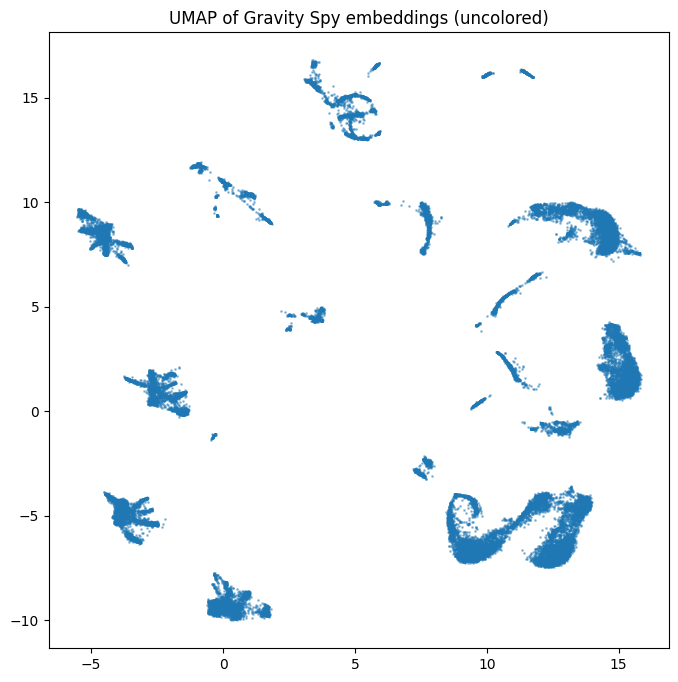

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(meta["umap_x"], meta["umap_y"], s=1, alpha=0.4)
plt.title("UMAP of Gravity Spy embeddings (uncolored)")
plt.show()


In [6]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=50,
    metric="euclidean",
    cluster_selection_method="eom",
)

cluster_labels = clusterer.fit_predict(meta[["umap_x", "umap_y"]].values)
meta["cluster_id"] = cluster_labels

meta["cluster_id"].value_counts().head()


cluster_id
41    3915
5     3697
28    3498
10    3479
33    2106
Name: count, dtype: int64

In [7]:
meta.to_csv("../data/gravityspy_processed/embeddings_umap_hdbscan.csv", index=False)


In [8]:
cluster_stats = (
    meta[meta["cluster_id"] != -1]  # exclude noise
      .groupby("cluster_id")
      .agg(
          n=("label_name", "size"),
          top_label=("label_name", lambda x: x.value_counts().idxmax()),
          top_label_count=("label_name", lambda x: x.value_counts().max()),
      )
)

cluster_stats["purity"] = cluster_stats["top_label_count"] / cluster_stats["n"]
cluster_stats.sort_values("n", ascending=False).head(15)


,n,top_label,top_label_count,purity
cluster_id,,,,
41,3915,H1L1,3915,1.0
5,3697,H1L1,3697,1.0
28,3498,H1L1,3498,1.0
10,3479,H1L1,3479,1.0
33,2106,H1L1,2106,1.0
15,1662,H1L1,1662,1.0
8,616,H1L1,616,1.0
20,603,H1L1,603,1.0
9,585,H1L1,585,1.0


In [9]:
import plotly.express as px

fig = px.scatter(
    meta,
    x="umap_x",
    y="umap_y",
    color="cluster_id",
    hover_data=["label_name", "path"],
    height=800,
    width=800,
)
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed